In [1]:
# ! pip install tqdm yfinance quantstats

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import yfinance as yf
import pandas as pd

start = '2006-01-01'
end = '2024-01-01'

assets = 'nasdaq100'
benchmark = 'NQ=F'

ldf = pd.read_html(f'https://www.slickcharts.com/{assets}', storage_options={'User-agent': 'Mozilla/5.0'})
symbols = [x.replace('.','-') for x in ldf[0]['Symbol'] if isinstance(x, str)]
downloads = yf.download([*symbols, benchmark], start, end, group_by='ticker')

data = downloads[symbols]
benchmark = downloads[benchmark]['Close']

[*********************100%%**********************]  102 of 102 completed


In [4]:
data

AAPL                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2006-01-03    2.585000    2.669643    2.580357    2.669643    2.263002   
2006-01-04    2.683214    2.713571    2.660714    2.677500    2.269663   
2006-01-05    2.672500    2.675000    2.633929    2.656429    2.251801   
2006-01-06    2.687500    2.739286    2.662500    2.725000    2.309928   
2006-01-09    2.740357    2.757143    2.705000    2.716071    2.302358   
...                ...         ...         ...         ...         ...   
2023-12-22  195.179993  195.410004  192.970001  193.600006  193.600006   
2023-12-26  193.610001  193.889999  192.830002  193.050003  193.050003   
2023-12-27  192.490005  193.500000  191.089996  193.149994  193.149994   
2023-12-28  194.139999  194.660004  193.169998  193.580002  193.580002   
2023-12-29  193.899994  194.399994  191.729996  192.529999  192.529999   

                               MSFT                                      ...  \
                 Volume        Open        High         Low       Close  ...   
Date                                                                     ...   
2006-01-03  807234400.0   26.250000   27.000000   26.100000   26.840000  ...   
2006-01-04  619603600.0   26.770000   27.080000   26.770000   26.969999  ...   
2006-01-05  449422400.0   26.959999   27.129999   26.910000   26.990000  ...   
2006-01-06  704457600.0   26.889999   27.000000   26.490000   26.910000  ...   
2006-01-09  675040800.0   26.930000   27.070000   26.760000   26.860001  ...   
...                 ...         ...         ...         ...         ...  ...   
2023-12-22   37122800.0  373.679993  375.179993  372.709991  374.579987  ...   
2023-12-26   28919300.0  375.000000  376.940002  373.500000  374.660004  ...   
2023-12-27   48087700.0  373.690002  375.059998  372.809998  374.070007  ...   
2023-12-28   34049900.0  375.369995  376.459991  374.160004  375.279999  ...   
2023-12-29   42628800.0  376.000000  377.160004  373.480011  376.040009  ...   

                  WBA                                    SIRI              \
                  Low      Close  Adj Close      Volume  Open  High   Low   
Date                                                                        
2006-01-03  44.340000  45.389999  28.610374   5217300.0  6.81  6.82  6.45   
2006-01-04  43.950001  43.980000  27.721609   5900300.0  6.45  6.50  6.28   
2006-01-05  43.400002  43.580002  27.469490   4568900.0  6.45  6.46  6.35   
2006-01-06  43.220001  43.369999  27.337111   4205500.0  6.50  6.54  6.40   
2006-01-09  43.049999  43.910000  27.677500   4396800.0  6.75  6.76  6.54   
...               ...        ...        ...         ...   ...   ...   ...   
2023-12-22  25.799999  26.219999  26.219999   9776300.0  5.48  5.49  5.39   
2023-12-26  26.200001  26.610001  26.610001  10181100.0  5.45  5.53  5.42   
2023-12-27  26.459999  26.639999  26.639999   8265500.0  5.49  5.57  5.44   
2023-12-28  26.389999  26.600000  26.600000   7899900.0  5.49  5.60  5.49   
2023-12-29  25.750000  26.110001  26.110001  10853300.0  5.52  5.52  5.42   

                                        
           Close Adj Close      Volume  
Date                                    
2006-01-03  6.52  5.691051  72062300.0  
2006-01-04  6.36  5.551394  63817600.0  
2006-01-05  6.39  5.577580  44321100.0  
2006-01-06  6.54  5.708508  42477400.0  
2006-01-09  6.57  5.734696  73075200.0  
...          ...       ...         ...  
2023-12-22  5.47  5.470000   8635000.0  
2023-12-26  5.50  5.500000   7249000.0  
2023-12-27  5.48  5.480000   8919800.0  
2023-12-28  5.53  5.530000   7115700.0  
2023-12-29  5.47  5.470000   8542800.0  

[4536 rows x 606 columns]

In [5]:
from btester import Strategy

def UpBreakout(ser: pd.Series, period: int):
    return (ser.rolling(period).max().diff() > 0).values

def DownBreakout(ser: pd.Series, period: int):
    return (ser.rolling(period).min().diff() < 0).values

class BreakoutStrategy(Strategy):
    buy_at_once_size = .01 # 1%

    def init(self, buy_period: int, sell_period: int):
        self.buy_signal = {}
        self.sell_signal = {}

        for symbol in self.symbols:
            self.buy_signal[symbol] = UpBreakout(self.data[(symbol,'Close')], buy_period)
            self.sell_signal[symbol] = DownBreakout(self.data[(symbol,'Close')], sell_period)

    def next(self, i, record):
        for symbol in self.symbols:
            if self.buy_signal[symbol][i-1]:
                self.open(symbol=symbol, price=record[(symbol,'Open')], size=self._positionSize(record[(symbol,'Open')]))

        for position in self.open_positions[:]:
            if self.sell_signal[position.symbol][i-1]:
                self.close(position=position, price=record[(position.symbol,'Open')])

    def _positionSize(self, price: float):
        return round((self.cash + self.cash_stock_value) / price * self.buy_at_once_size) if price > 0 else 0

In [6]:
from btester import Backtest
backtest = Backtest(BreakoutStrategy, data, commission=.001, cash=1e6)

In [7]:
import pandas as pd
import quantstats as qs
from itertools import product
from tqdm.contrib.concurrent import process_map

parameters = ['Buy period','Sell period']
values = [[5, 10, 20, 50, 75, 100, 150, 200], [5, 10, 20, 50, 75, 100, 150, 200]]

def run(v):
    result = backtest.run(*v)
    returns = result.returns
    return [*v, returns.iloc[0], returns.iloc[-1], qs.stats.max_drawdown(returns) * 100, qs.stats.cagr(returns) * 100, qs.stats.sharpe(returns)]

optimization_results = process_map(run, list(product(*values)))
optimization_results = pd.DataFrame(optimization_results, columns=[*parameters,'Initial Capital','Cumulative Return','Max Drawdown (%)','CAGR (%)','Sharpe Ratio'])
optimization_results.set_index([*parameters], inplace=True)

100%|██████████| 64/64 [00:29<00:00,  2.19it/s]


In [8]:
optimization_results_sorted = optimization_results.sort_values('Sharpe Ratio', ascending=False)
optimization_results_sorted

Initial Capital  Cumulative Return  Max Drawdown (%)  \
Buy period Sell period                                                         
20         100             1.000044e+06       3.938022e+07        -35.745374   
5          75              1.000350e+06       5.296988e+07        -50.495765   
20         75              1.000044e+06       3.587932e+07        -40.117509   
5          100             1.000350e+06       4.180663e+07        -53.376220   
           50              1.000350e+06       3.523947e+07        -50.331383   
...                                 ...                ...               ...   
75         5               1.000000e+06       1.183799e+06        -29.146472   
50         5               1.000000e+06       1.190721e+06        -33.105845   
200        5               1.000000e+06       1.082152e+06        -30.317287   
100        5               1.000000e+06       1.051097e+06        -32.133251   
150        5               1.000000e+06       1.023543e+06        -32.506856   

                         CAGR (%)  Sharpe Ratio  
Buy period Sell period                           
20         100          15.132338      1.107580  
5          75           16.447823      1.095960  
20         75           14.721865      1.064722  
5          100          15.395369      1.059899  
           50           14.641356      1.056548  
...                           ...           ...  
75         5             0.649375      0.147313  
50         5             0.671889      0.147180  
200        5             0.303333      0.094677  
100        5             0.191359      0.075813  
150        5             0.089309      0.057626  

[64 rows x 5 columns]

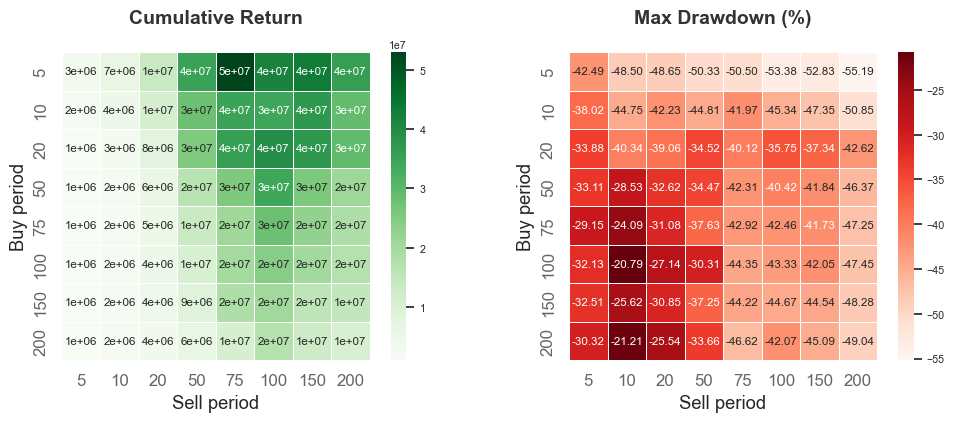

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].set_title('Cumulative Return\n', fontsize=14, fontweight='bold')
ax[1].set_title('Max Drawdown (%)\n', fontsize=14, fontweight='bold')

reshape = lambda d: pd.DataFrame(d.values.reshape(len(d.index.levels[0]), len(d.index.levels[1])), d.index.levels[0], d.index.levels[1])

sns.set(font_scale=.7)
sns.heatmap(reshape(optimization_results['Cumulative Return']), ax=ax[0], annot=True, fmt='.0g', linewidth=.5, square=True, cmap='Greens')
sns.heatmap(reshape(optimization_results['Max Drawdown (%)']), ax=ax[1], annot=True, fmt='.2f', linewidth=.5, square=True, cmap='Reds')

plt.show()

In [10]:
best_params = optimization_results_sorted.index[0]
best_params

(20, 100)

In [11]:
result = backtest.run(*best_params)

In [12]:
import quantstats as qs
qs.reports.metrics(result.returns, benchmark)

                    Benchmark      Strategy
------------------  -------------  ------------------------
Start Period        2006-01-03     2006-01-03
End Period          2023-12-29     2023-12-29
Risk-Free Rate      0.0%           0.0%
Time in Market      100.0%         100.0%

Cumulative Return   905.52%        -
CAGR﹪              9.26%          15.13%

Sharpe              0.69           1.11
Prob. Sharpe Ratio  99.82%         100.0%
Sortino             0.97           1.58
Sortino/√2          0.69           1.12
Omega               1.21           1.21

Max Drawdown        -53.85%        -
Longest DD Days     1161           6498

Gain/Pain Ratio     0.14           0.21
Gain/Pain (1M)      0.83           1.49

Payoff Ratio        0.87           0.93
Profit Factor       1.14           -
Common Sense Ratio  1.04           1.16
CPC Index           0.55           0.63
Tail Ratio          0.92           32.76
Outlier Win Ratio   2243140601.65  1.76
Outlier Loss Ratio  -49844874.9    -

MTD 

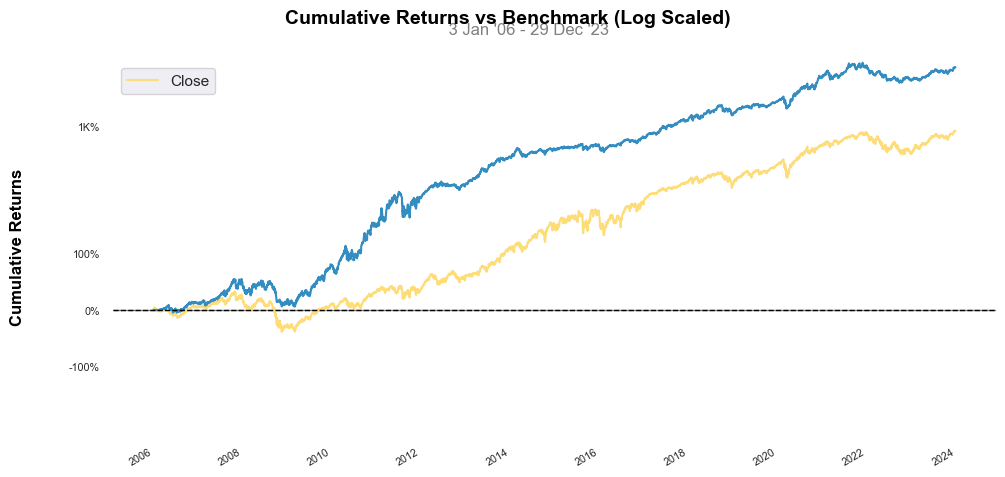

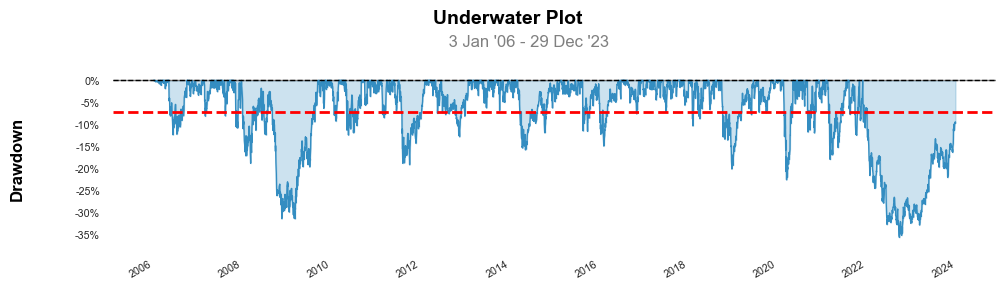

In [13]:
qs.plots.log_returns(result.returns, benchmark)
qs.plots.drawdown(result.returns, figsize=(10,3))

In [14]:
trades = pd.DataFrame(result.trades)
trades.tail(15)

,symbol,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
1621,AMAT,2023-03-15,2023-10-26,118.519997,131.110001,2521,31739.400002,10.622683,629.317223,2.841807e+07
1622,AMD,2022-11-07,2023-10-27,62.930000,95.800003,4830,158762.113266,52.232644,766.665916,2.857607e+07
1623,TSLA,2023-02-07,2023-10-27,196.429993,210.600006,1560,22105.220947,7.213773,634.966798,2.859754e+07
1624,AAPL,2023-02-08,2023-10-27,153.880005,166.910004,2011,26203.327545,8.467636,645.108707,2.862310e+07
1625,AMD,2023-03-15,2023-10-27,86.769997,95.800003,3443,31090.312065,10.406830,628.588509,2.865356e+07
1626,AAPL,2023-03-17,2023-10-27,156.080002,166.910004,1937,20977.713547,6.938750,625.631641,2.867391e+07
1627,AAPL,2023-03-27,2023-10-27,159.940002,166.910004,1920,13382.402344,4.357885,627.552012,2.868666e+07
1628,AAPL,2023-05-22,2023-10-27,173.979996,166.910004,1909,-13496.614853,-4.063681,650.759009,2.867252e+07
1629,TSLA,2023-05-22,2023-10-27,180.699997,210.600006,1838,54956.216827,16.546768,719.209406,2.872675e+07
1630,AAPL,2023-05-30,2023-10-27,176.960007,166.910004,1928,-19376.405884,-5.679251,662.981380,2.870671e+07


In [15]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value
0,VRTX,2021-12-02,2023-12-29,201.820007,406.890015,2026,415471.834839,101.610346,824359.169678
1,VRTX,2022-01-31,2023-12-29,240.869995,406.890015,1444,239732.908203,68.925156,587549.181152
2,VRTX,2022-02-01,2023-12-29,242.389999,406.890015,1477,242966.522537,67.865843,600976.551636
3,VRTX,2022-02-02,2023-12-29,243.580002,406.890015,1472,240392.338867,67.045739,598942.101562
4,VRTX,2022-02-03,2023-12-29,250.160004,406.890015,1443,226161.405853,62.651906,587142.291138
...,...,...,...,...,...,...,...,...,...
80,MSFT,2023-11-03,2023-12-29,349.630005,376.040009,1013,26753.333710,7.553701,380928.528656
81,AMZN,2023-11-03,2023-12-29,138.990005,151.940002,2547,32983.642227,9.317215,386991.186218
82,PEP,2023-11-03,2023-12-29,168.679993,169.839996,2099,2434.847687,0.687695,356494.152313
83,AVGO,2023-11-20,2023-12-29,973.000000,1116.250000,379,54291.750000,14.722508,423058.750000
